# Loan Default

In [373]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_csv('data/SBAnational.csv')

/var/folders/kl/1td686bd539f1dpck8lw65900000gn/T/ipykernel_96994/2298317485.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/SBAnational.csv')


In [282]:
df = data.copy()

In [283]:
df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

## EDA and Preprocessing

So, first things first. The dataset contains loans up to 2014. If all loans are kept, we will have a strong bias in the dataset caused by those loans that haven’t reached maturity yet (i.e., the date by which loans are supposed to be fully paid). These loans that have not reached maturity appear to not have defaulted; however, it is impossible to tell if they will actually default in the future since they have not yet been paid in full. So, to begin with, we will calculate the loan maturity year and if this year is greater than 2014, we will drop those loans to avoid introducing bias to the dataset. To accomplish this, we will engineer some features. Moreover, we will be dealing with other issues the dataset has. I will try to explain as best as I can each step.

First let's look at our target column. Whether the loans have been paid in full, defaulted, or null

In [285]:
print(df['MIS_Status'].value_counts())
print((df['MIS_Status']).isnull().sum())

MIS_Status
P I F     739609
CHGOFF    157558
Name: count, dtype: int64
1997


We will be creating a binary predictor for this column as our target. However, first we need to clean the data before we look at the spread of the columns, as rows will likely be dropped.

We will begin our EDA by looking at the dates the loan was approved as well as the date the loan was actually given(disbursement). Let's format these properly by turning them into datetime.

In [286]:
#code from: https://www.kaggle.com/code/ricardocolindres/loan-default-prediction-loan-parameter-optimizer
# pandas will assume all years that are only the last 2 digits are after 2000. 
#So we need to reformat the year
def get_date(x):
    if type(x) == float:
        return None
    else:
        date = x.split('-')
        year = date[2] 
        if year == '00':
            year = '20' + year
        elif year == '20':
            year = '20' + '00'
        elif int(year) > 20:
            year = '19' + year
        else:
            year = '20' + year
        return f'{date[0]}-{date[1]}-{year}'

# Convert datetime fields into proper data type and apply get_date function
df['approval_date'] = pd.to_datetime(df['ApprovalDate'].apply(get_date))
df['disbursement_date'] = pd.to_datetime(df['DisbursementDate'].apply(get_date))
df['chg_off_date'] = pd.to_datetime(df['ChgOffDate'].apply(get_date))

In [287]:
#sample the new columns
print(df['approval_date'].head())
print(df['disbursement_date'].head())

0   1997-02-28
1   1997-02-28
2   1997-02-28
3   1997-02-28
4   1997-02-28
Name: approval_date, dtype: datetime64[ns]
0   1999-02-28
1   1997-05-31
2   1997-12-31
3   1997-06-30
4   1997-05-14
Name: disbursement_date, dtype: datetime64[ns]


Now let's make sure that all the disbursement dates are later or the same as the approval dates.

In [288]:
#create boolean values if disbursement date is later
df['is_disbursement_later'] = df['disbursement_date'] >= df['approval_date']

#print value counts normally and as percentages
print(df['is_disbursement_later'].value_counts())
print(df['is_disbursement_later'].value_counts(normalize=True) * 100)

is_disbursement_later
True     895987
False      3177
Name: count, dtype: int64
is_disbursement_later
True     99.646672
False     0.353328
Name: proportion, dtype: float64


We see that there are some rows where the disbursement date was earlier. Since it's such a small percentage of the overall data, let's go ahead and drop those rows, as there may be additional input inaccuracies. 

In [289]:
#drop rows with earlier disbursement date
df = df[df['disbursement_date'] >= df['approval_date']]
len(df)

895987

Now let's continue with more datetime stuff. Let's convert the `ChgOffDate` column to datetime, and pull the year out of it. Additionally, let's get a well formatted year `approved_year` column

In [290]:
# Get the year from approval_date and chg_off_date
df['approved_year'] = df['approval_date'].apply(lambda x: int(x.year))
df['chg_off_year'] = df['chg_off_date'].apply(lambda x: int(x.year) if not x is pd.NaT else None).astype('Int64')

Now let's drop all the columns we for sure don't need at this point. This includes columns that we reformatted into different columns, as well as the `Name` column as the name of the person issued the loan has no affect on whether they defaulted.

In [291]:
# Drop features that will definetly not be used. 
# DisbursmentData, ApprovalDate and ChgOffDate have been turned into diff features
# Finally, we are not concerned with the individual names of the credit holders,
# but rather their information. Thus, we will drop the name column. 
df = df.drop(['DisbursementDate', 'ApprovalDate', 'Name', 
              'ChgOffDate', 'ApprovalFY', 'is_disbursement_later'], axis=1) 

Now let's create a column to see the date and year when each of the loans were due.

In [292]:
# Get disbursement year
df['disbursement_year'] = df['disbursement_date'].dt.year.astype('Int64')
#add the Term of the loan to the disbursement date to get the date when the loan was due
df['loan_maturity_date'] = df.apply(lambda x: x['disbursement_date'] + 
                                    pd.DateOffset(months = x['Term']), axis=1)
# Get loan maturity year
df['loan_maturity_year'] = df['loan_maturity_date'].dt.year.astype('Int64')

Since the dataset only goes till 2014, all loans that are due beyond 2014 will appear to be paid back eventhough they really have not been tracked. As such we will drop all those that extend beyond 2014, except for the ones that have already defaulted. Additionally, we will drop all loans that have a NaN default status.

In [293]:
#calculate length of df before the drop
original_length = len(df)
#drop loans that status is Paid in Full yet extend beyond 2014
df = df.drop(df[(df['MIS_Status'] == 'P I F') & (df['loan_maturity_year'] > 2014)].index)

# Loans that have no default status and extend beyond 2014 will also be dropped.
df = df.drop(df[(df['MIS_Status'].isnull()) & (df['loan_maturity_year'] > 2014)].index) #242 dicarded
df.head()

,LoanNr_ChkDgt,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,...,GrAppv,SBA_Appv,approval_date,disbursement_date,chg_off_date,approved_year,chg_off_year,disbursement_year,loan_maturity_date,loan_maturity_year
0,1000014003,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,84,4,2.0,...,"$60,000.00","$48,000.00",1997-02-28,1999-02-28,NaT,1997,<NA>,1999,2006-02-28,2006
1,1000024006,NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,60,2,2.0,...,"$40,000.00","$32,000.00",1997-02-28,1997-05-31,NaT,1997,<NA>,1997,2002-05-31,2002
2,1000034009,BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,180,7,1.0,...,"$287,000.00","$215,250.00",1997-02-28,1997-12-31,NaT,1997,<NA>,1997,2012-12-31,2012
3,1000044001,BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,1.0,...,"$35,000.00","$28,000.00",1997-02-28,1997-06-30,NaT,1997,<NA>,1997,2002-06-30,2002
5,1000084002,PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,120,19,1.0,...,"$517,000.00","$387,750.00",1997-02-28,1997-06-30,NaT,1997,<NA>,1997,2007-06-30,2007


In [294]:
print(f'We dropped: {original_length - len(df)} rows')
print(f'Our new df shape is {df.shape}')

We dropped: 197957 rows
Our new df shape is (698030, 30)


Now let's check out what other columns need to be cleaned.

In [295]:
df.isna().sum()

LoanNr_ChkDgt              0
City                      30
State                     13
Zip                        0
Bank                    1458
BankState               1465
NAICS                      0
Term                       0
NoEmp                      0
NewExist                  40
CreateJob                  0
RetainedJob                0
FranchiseCode              0
UrbanRural                 0
RevLineCr               3344
LowDoc                  1482
DisbursementGross          0
BalanceGross               0
MIS_Status              1561
ChgOffPrinGr               0
GrAppv                     0
SBA_Appv                   0
approval_date              0
disbursement_date          0
chg_off_date          536030
approved_year              0
chg_off_year          536030
disbursement_year          0
loan_maturity_date         0
loan_maturity_year         0
dtype: int64

Being that `chg_off_date` and `chg_off_year` are mostly NaN values let's drop those columns

In [296]:
df = df.drop(columns=[ 'chg_off_date','chg_off_year'], axis=1)
df.shape

(698030, 28)

In [297]:
df.isna().sum()

LoanNr_ChkDgt            0
City                    30
State                   13
Zip                      0
Bank                  1458
BankState             1465
NAICS                    0
Term                     0
NoEmp                    0
NewExist                40
CreateJob                0
RetainedJob              0
FranchiseCode            0
UrbanRural               0
RevLineCr             3344
LowDoc                1482
DisbursementGross        0
BalanceGross             0
MIS_Status            1561
ChgOffPrinGr             0
GrAppv                   0
SBA_Appv                 0
approval_date            0
disbursement_date        0
approved_year            0
disbursement_year        0
loan_maturity_date       0
loan_maturity_year       0
dtype: int64


Being that our dataframe is so large, and the rows that contain missing data make up roughly 1% of the data we will drop all the rows with missing values.

In [298]:
df = df.dropna()
df.isna().sum()

LoanNr_ChkDgt         0
City                  0
State                 0
Zip                   0
Bank                  0
BankState             0
NAICS                 0
Term                  0
NoEmp                 0
NewExist              0
CreateJob             0
RetainedJob           0
FranchiseCode         0
UrbanRural            0
RevLineCr             0
LowDoc                0
DisbursementGross     0
BalanceGross          0
MIS_Status            0
ChgOffPrinGr          0
GrAppv                0
SBA_Appv              0
approval_date         0
disbursement_date     0
approved_year         0
disbursement_year     0
loan_maturity_date    0
loan_maturity_year    0
dtype: int64

Now that there are no NaN values in our df, the next step is to look through all the columns and make sure that they are ready for modeling. First we will make sure that they are the right data type. Then we will make sure there are no filler values in them. Finally, we will decide if there is a better way to group the data.

In [299]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 690118 entries, 0 to 899163
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   LoanNr_ChkDgt       690118 non-null  int64         
 1   City                690118 non-null  object        
 2   State               690118 non-null  object        
 3   Zip                 690118 non-null  int64         
 4   Bank                690118 non-null  object        
 5   BankState           690118 non-null  object        
 6   NAICS               690118 non-null  int64         
 7   Term                690118 non-null  int64         
 8   NoEmp               690118 non-null  int64         
 9   NewExist            690118 non-null  float64       
 10  CreateJob           690118 non-null  int64         
 11  RetainedJob         690118 non-null  int64         
 12  FranchiseCode       690118 non-null  int64         
 13  UrbanRural          690118 non-nul

,LoanNr_ChkDgt,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,...,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,approval_date,disbursement_date,approved_year,disbursement_year,loan_maturity_date,loan_maturity_year
0,1000014003,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,84,4,2.0,...,P I F,$0.00,"$60,000.00","$48,000.00",1997-02-28,1999-02-28,1997,1999,2006-02-28,2006
1,1000024006,NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,60,2,2.0,...,P I F,$0.00,"$40,000.00","$32,000.00",1997-02-28,1997-05-31,1997,1997,2002-05-31,2002
2,1000034009,BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,180,7,1.0,...,P I F,$0.00,"$287,000.00","$215,250.00",1997-02-28,1997-12-31,1997,1997,2012-12-31,2012
3,1000044001,BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,1.0,...,P I F,$0.00,"$35,000.00","$28,000.00",1997-02-28,1997-06-30,1997,1997,2002-06-30,2002
5,1000084002,PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,120,19,1.0,...,P I F,$0.00,"$517,000.00","$387,750.00",1997-02-28,1997-06-30,1997,1997,2007-06-30,2007


Before we move on, let's reset the index

In [300]:
df.reset_index(drop=True, inplace=True)

In [301]:
df.head()

,LoanNr_ChkDgt,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,...,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,approval_date,disbursement_date,approved_year,disbursement_year,loan_maturity_date,loan_maturity_year
0,1000014003,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,84,4,2.0,...,P I F,$0.00,"$60,000.00","$48,000.00",1997-02-28,1999-02-28,1997,1999,2006-02-28,2006
1,1000024006,NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,60,2,2.0,...,P I F,$0.00,"$40,000.00","$32,000.00",1997-02-28,1997-05-31,1997,1997,2002-05-31,2002
2,1000034009,BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,180,7,1.0,...,P I F,$0.00,"$287,000.00","$215,250.00",1997-02-28,1997-12-31,1997,1997,2012-12-31,2012
3,1000044001,BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,1.0,...,P I F,$0.00,"$35,000.00","$28,000.00",1997-02-28,1997-06-30,1997,1997,2002-06-30,2002
4,1000084002,PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,120,19,1.0,...,P I F,$0.00,"$517,000.00","$387,750.00",1997-02-28,1997-06-30,1997,1997,2007-06-30,2007


We have already taken care of all the columns that deal with time so we don't have to worry about those. 
Note: that for all of these columns I seperately pulled up the value counts so none of it is in this notebook.
   - Being that the `LoanNr_ChkDgt` column is the id, we will need to change that to object type. (DONE)
   -  Being that `City` and `Zip` contain over 28,000 values with no great way to combine them, we will drop these columns for the modeling and only keep the `State` column. (keep the columns for EDA to map them on a map of the USA). We may later on decide to add them back in, or group them in such a way that we can add them, but for now we will drop them. 
       - `Zip` has 31.6k total. see below
       - `City` is 28.5k, see below
       (drop/ ask Morgan)
   - `State` needs to be broken into dummy rows(DONE)
   - `Bank` has 5440 different values, we will regroup this column into a few columns based on value counts, and one hot encode the column. 
       - If there are more than 10000 value counts we will say the bank is Huge(8 counts)
       - If more than 1000 than very_large(58 counts), 
       - If more than 100 we'll say large(~500). 
       - If more than 25 than small(~1000), 
       - If more than 5 than very_small(~1600), 
       - Below 5(~2200) then tiny. 
       (DONE)
   - `BankState`, has 5 states that appear less than 1000 times, so we will combine them as `other`. then OHE the column(DONE)
   - `NAICS` is a classification code for the business so this will also be changed to object. Additionally only the first 2 digits are important. Of which certain values mean the same thing. So we also need to create a dictionary to rename the values. Then we will get dummy columns for the whole column(DONE)
   - `Term` which is the loan length will remain the same. (DONE)
   - `NoEmp` which describes the number of employees will remain the same.(DONE)
   - `NewExist` contains only 1s and 2s whether the business is existing or new. So we'll rename the column `Existing`, and change this to a boolean value, all values that are not 1 or 2 we will drop those rows(only 702 rows).  (DONE)
   - `CreateJob` and `RetainJob` give information about the number of jobs created and retained, these will remain the same (DONE)
   - `FranchiseCode` contains the franchise codes, the codes 00000 and 00001 means that its not a franchise. There are 2472 value counts, of which only 1861 appear over 10 times. As such we rename the column `large_franchise`, and make it a boolean value if there are 10 or more branches in the df.
       - Most are no franchise, so if over 10000 value counts we will store it as None
       - over 100 is large(~400), 
       - over 5 is medium (~800)
       - over 1 is small (~800)
       - 1 is one(~800)
   - `UrbanRural` contains a 0,1 or 2 if its undefined, urban or rural. We will rename the values based on its true meaning and ohe it. (DONE?)
   - `RevLineCr` states whether the business has a revolving line of credit, the values are str Y or N. We will switch these to boolean values. (DONE?)
   - `LowDoc` says whether the loan was from the LowDoc Loan Program. This program is a specific loan program that was offered by the Small Business Administration in the United States. It was designed to streamline the loan application process for small businesses by requiring less documentation compared to traditional loan programs. This column also contains Y and N, as such we will switch it to boolean values. We will drop all rows that are not Y or N(around 1500 rows).(DONE)
   - `MIS_Status` is our target column whether the loan was paid in full or defaulted, as such we will rename the column `Paid` and then change it to boolean values.(DONE)
   - The last 5 columns all contain monetary amounts with dollar signs, commas, and periods, as such they are stored as a str. We will reformat them as int values.
   - `DisbursementGross` contains the amount given.
   - `BalanceGross` contains the gross amount that is still due.
   - `ChgOffPrinGr` represents the amount of debt that the lender considers unlikely to be fully repaid and removes it from their active accounts receivable. 
   - `GrAppv` column indicates the gross amount of money that a bank or lending institution has approved to lend to a borrower. 
   - `SBA_Appv` column indicates the specific amount that the Small Business Administration guarantees to pay back, should the borrower not.
   (DONE)
   
   -all thats left is: RevLineCr and UrbanRural. Morgan:try out diff ways with imputing, ohe or dropping on a basic decision tree and go with the best way.
   -drop zip and city except for visualizations

For the first step in out cleaning let's change all the columns that are need to be stored as strings into strings. This includes the `LoanNr_ChkDgt`, and `NAICS` column, as the first is the id code and the second is a classification code

In [302]:
#make a list of columns to change data type
cols = ['LoanNr_ChkDgt', 'NAICS']

#create a for loop to change the dtypes of each to string
for col in cols:
    df[col] = df[col].astype(str)

#sample NAICS
df.NAICS.dtype

dtype('O')

Now that we have already begun the cleaning on the `NAICS` column, let's finish it up. First, we'll strip all but the first 2 numbers, as they are the only important ones. Next, we will create a dictionary to rename the values based on the general category in which they fall.

In [303]:
df['NAICS'].value_counts()

NAICS
0         160216
722110     19935
722211     14646
811111     10516
621210      9120
           ...  
112130         1
514190         1
311351         1
316212         1
336415         1
Name: count, Length: 1301, dtype: int64

In [304]:
#ONLY RUN THIS ONCE
#pull out only the first 2 digits
df['NAICS'] = df['NAICS'].str.slice(stop=2)

In [305]:
#use dictionary to store values together
rename_dict = {
    '0': 'Unidentified',
    '11': 'Agriculture',
    '21': 'Mining',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale',
    '44': 'Retail',
    '45': 'Retail',
    '48': 'Transportation_Warehousing',
    '49': 'Transportation_Warehousing',
    '51': 'Information',
    '52': 'Finance_Insurance',
    '53': 'Real_Estate',
    '54': 'Professional_services',
    '55': 'Management',
    '56': 'Administration_service',
    '61': 'Education',
    '62': 'Health_care',
    '71': 'Arts',
    '72': 'Accomodation_Food',
    '81': 'Other_services',
    '92': 'Public_administration'
}

df['NAICS'] = df['NAICS'].replace(rename_dict)

df.NAICS.value_counts()

NAICS
Unidentified                  160216
Retail                        100359
Other_services                 54756
Construction                   53287
Professional_services          52286
Manufacturing                  50791
Accomodation_Food              45081
Wholesale                      37788
Health_care                    37755
Administration_service         27404
Transportation_Warehousing     18594
Arts                           10692
Real_Estate                    10431
Information                     9440
Finance_Insurance               7178
Agriculture                     6843
Education                       4860
Mining                          1494
Utilities                        559
Public_administration            200
Management                       104
Name: count, dtype: int64

Now let's get dummy variables for the column as it is categorical. We'll create a function that we can re-use for this.

In [306]:
def dummy_cols_and_drop(df, column, new_drop_dummy_value):
    #create dummy columns
    encoded_cols = pd.get_dummies(df[column], prefix=column)
    
    #drop the unidentified column
    encoded_cols.drop(f'{column}_{new_drop_dummy_value}', axis=1, inplace=True)
    
    #Switch the values from T and F to 1 and 0
    encoded_cols = encoded_cols.astype(int)
    
    #concatenate new dummy df with old df.
    df = pd.concat([df.drop(column, axis=1), encoded_cols], axis=1)
    
    return df

In [307]:
df = dummy_cols_and_drop(df, 'NAICS', 'Unidentified')

In [308]:
df.head()

,LoanNr_ChkDgt,City,State,Zip,Bank,BankState,Term,NoEmp,NewExist,CreateJob,...,NAICS_Manufacturing,NAICS_Mining,NAICS_Other_services,NAICS_Professional_services,NAICS_Public_administration,NAICS_Real_Estate,NAICS_Retail,NAICS_Transportation_Warehousing,NAICS_Utilities,NAICS_Wholesale
0,1000014003,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,84,4,2.0,0,...,0,0,0,0,0,0,1,0,0,0
1,1000024006,NEW PARIS,IN,46526,1ST SOURCE BANK,IN,60,2,2.0,0,...,0,0,0,0,0,0,0,0,0,0
2,1000034009,BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,180,7,1.0,0,...,0,0,0,0,0,0,0,0,0,0
3,1000044001,BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,60,2,1.0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000084002,PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,120,19,1.0,0,...,1,0,0,0,0,0,0,0,0,0


In [309]:
#DELETE THIS AT THE END. ITS JUST A CHECK POINT
fr = df.copy()

Next we will work on the `Bank` and `FranchiseCode` columns. Both of these columns need to have thousands of value counts and need to be turned into dummy columns. However, it isn't efficient for our modeling if we one hot encode all the banks or codes. As such we will rename each value based on the amount of value counts in the dataframe. We'll start with the `Bank` column. We'll break it down like this:
- If there are more than 10000 value counts(vcs) of a certain bank we will say the bank is Huge(12 counts)
- If more than 1000 vcs then very_large(58 counts),
- If more than 100 we'll say large(~500).
- If more than 25 then small(~1000),
- If more than 5 then very_small(~1600),
- Below 5(~2200) then tiny.

In [310]:
df.Bank.value_counts()

Bank
BANK OF AMERICA NATL ASSOC        82928
WELLS FARGO BANK NATL ASSOC       50007
JPMORGAN CHASE BANK NATL ASSOC    39495
CITIZENS BANK NATL ASSOC          31853
U.S. BANK NATIONAL ASSOCIATION    25491
                                  ...  
BEACH PLAZA LLC                       1
BANCORPSOUTH, INC.                    1
1ST NATL BK OF ODON                   1
BANK OF WOLCOTT                       1
DEPCO                                 1
Name: count, Length: 5440, dtype: int64

In [311]:
# create ranges of value counts to relabel values
def map_bank(count):
    if count >= 10000:
        return 'huge'
    elif 1000 <= count < 10000:
        return 'very_large'
    elif 100 <= count < 1000:
        return 'large'
    elif 25 <= count < 100:
        return 'small'
    elif 5 <= count < 25:
        return 'very_small'
    else:
        return 'tiny'

In [312]:
# create function to apply the mapping function to desired column column
def rename_w_vcs(df, column, vc_map):
    # create dictionary of value counts
    column_dict = df[column].value_counts().to_dict()
    #replace bank name with value count, then replace count with new name
    df[column] = df[column].map(column_dict).map(vc_map)
    
    return df

In [313]:
rename_w_vcs(df, 'Bank', map_bank)

,LoanNr_ChkDgt,City,State,Zip,Bank,BankState,Term,NoEmp,NewExist,CreateJob,...,NAICS_Manufacturing,NAICS_Mining,NAICS_Other_services,NAICS_Professional_services,NAICS_Public_administration,NAICS_Real_Estate,NAICS_Retail,NAICS_Transportation_Warehousing,NAICS_Utilities,NAICS_Wholesale
0,1000014003,EVANSVILLE,IN,47711,very_large,OH,84,4,2.0,0,...,0,0,0,0,0,0,1,0,0,0
1,1000024006,NEW PARIS,IN,46526,large,IN,60,2,2.0,0,...,0,0,0,0,0,0,0,0,0,0
2,1000034009,BLOOMINGTON,IN,47401,very_small,IN,180,7,1.0,0,...,0,0,0,0,0,0,0,0,0,0
3,1000044001,BROKEN ARROW,OK,74012,small,OK,60,2,1.0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000084002,PLAINVILLE,CT,6062,very_large,DE,120,19,1.0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690113,9995573004,UPPER ARLINGTON,OH,43221,huge,IL,60,6,1.0,0,...,0,0,0,0,0,0,1,0,0,0
690114,9995603000,COLUMBUS,OH,43221,huge,IL,60,6,1.0,0,...,0,0,0,0,0,0,1,0,0,0
690115,9995613003,SANTA MARIA,CA,93455,very_large,CA,108,26,1.0,0,...,1,0,0,0,0,0,0,0,0,0
690116,9995973006,HONOLULU,HI,96830,very_large,HI,60,6,1.0,0,...,0,0,0,0,0,0,0,0,0,0


In [314]:
print(df.Bank.value_counts())
df.head()

Bank
huge          297233
very_large    181721
large         138537
small          47610
very_small     20950
tiny            4067
Name: count, dtype: int64


,LoanNr_ChkDgt,City,State,Zip,Bank,BankState,Term,NoEmp,NewExist,CreateJob,...,NAICS_Manufacturing,NAICS_Mining,NAICS_Other_services,NAICS_Professional_services,NAICS_Public_administration,NAICS_Real_Estate,NAICS_Retail,NAICS_Transportation_Warehousing,NAICS_Utilities,NAICS_Wholesale
0,1000014003,EVANSVILLE,IN,47711,very_large,OH,84,4,2.0,0,...,0,0,0,0,0,0,1,0,0,0
1,1000024006,NEW PARIS,IN,46526,large,IN,60,2,2.0,0,...,0,0,0,0,0,0,0,0,0,0
2,1000034009,BLOOMINGTON,IN,47401,very_small,IN,180,7,1.0,0,...,0,0,0,0,0,0,0,0,0,0
3,1000044001,BROKEN ARROW,OK,74012,small,OK,60,2,1.0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000084002,PLAINVILLE,CT,6062,very_large,DE,120,19,1.0,0,...,1,0,0,0,0,0,0,0,0,0


Great, we see that since the 8 biggest banks represented most values, they are now the largest value counts. The although there were many banks with less than 5 value counts since they appear so few times they represent a very small portion of the data. Now let's create dummy columns for this column, using our function from earlier.

In [315]:
df = dummy_cols_and_drop(df, 'Bank', 'tiny')

In [316]:
df.head()

,LoanNr_ChkDgt,City,State,Zip,BankState,Term,NoEmp,NewExist,CreateJob,RetainedJob,...,NAICS_Real_Estate,NAICS_Retail,NAICS_Transportation_Warehousing,NAICS_Utilities,NAICS_Wholesale,Bank_huge,Bank_large,Bank_small,Bank_very_large,Bank_very_small
0,1000014003,EVANSVILLE,IN,47711,OH,84,4,2.0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,1000024006,NEW PARIS,IN,46526,IN,60,2,2.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1000034009,BLOOMINGTON,IN,47401,IN,180,7,1.0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1000044001,BROKEN ARROW,OK,74012,OK,60,2,1.0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1000084002,PLAINVILLE,CT,6062,DE,120,19,1.0,0,0,...,0,0,0,0,0,0,0,0,1,0


Now let's do the same for `FranchiseCode` just with slightly different value count replacement values. Additionally, the most common values, appearing over 10000 times, are 0 and 1 which means that they are not a franchise. As such we will make these changes:
- If over 10000 value counts(vcs) we will store it as 'none'
- between 100 and 10000 is large(~400),
- between 5 and 100 is medium (~800)
- between 1 and 5 is small (~800)
- 1 is one(~800)

We'll create a map based on these values and then run our 2 functions from earlier.

In [317]:
df.FranchiseCode.value_counts()

FranchiseCode
1        496398
0        155465
78760      2750
68020      1680
50564       998
          ...  
47746         1
60794         1
77500         1
82141         1
81560         1
Name: count, Length: 2472, dtype: int64

Being that roughly 650,000 out of the 700,000 rows have no franchise. Let's actually just turn this column into a boolean whether the business is a franchise or not. Being that the value_counts of non franchises are over 10k, and all the businesses that are franchises are below 10k let's use the function from before.


In [318]:
df.FranchiseCode.value_counts()

FranchiseCode
1        496398
0        155465
78760      2750
68020      1680
50564       998
          ...  
47746         1
60794         1
77500         1
82141         1
81560         1
Name: count, Length: 2472, dtype: int64

In [319]:
#change the 1 to a 0 and keep the 0 as 0. Change all other values to a 1. Rename the column
df['is_franchise'] = df['FranchiseCode'].apply(lambda x: 0 if x in (0,1) else 1)

#Drop the old row
df.drop(columns='FranchiseCode', axis=1, inplace=True)

#confirm it worked
df.is_franchise.value_counts()

is_franchise
0    651863
1     38255
Name: count, dtype: int64

Great, this also worked. As we saw, most of these are going to be all zeros as the vast majority of our data is from no franchised businesses.

Now we move on to `BankState`. This column contains the state of the bank giving the loan. However, all the states have value counts over 1000 except for 5, which seem like US territories and have very low value counts. As such we will create store these values as other.

Let's pull up the value counts to start

In [320]:
df.BankState.value_counts().tail(15)

BankState
NM    3371
ID    2913
ME    2856
NV    2775
HI    2584
DC    2145
AZ    2051
WY    1727
WV    1720
AK    1306
PR     138
GU       4
AN       1
EN       1
VI       1
Name: count, dtype: int64

In [321]:
#create dict to replace values
bankstate_dict = {'PR': 'other',
                  'GU': 'other',
                  'AN': 'other',
                  'EN': 'other',
                  'VI': 'other'}

#replace values based on dict
df['BankState'] = df['BankState'].replace(bankstate_dict)

In [322]:
df.BankState.value_counts().tail(5)

BankState
AZ       2051
WY       1727
WV       1720
AK       1306
other     145
Name: count, dtype: int64

In [323]:
df.State.value_counts().tail(5)

State
WV    2756
WY    2208
AK    2051
DE    1907
DC    1323
Name: count, dtype: int64

Now let's create dummy columns for the `State` and `BankState` columns. We'll drop 'DC' from `State` and the 'other' column from `BankState` as they have the least value counts.

In [324]:
#create dummy columns and drop the other column
df = dummy_cols_and_drop(df, 'BankState', 'other')

#create dummy columns and drop the DC column
df = dummy_cols_and_drop(df, 'State', 'DC')

In [325]:
df.head()

,LoanNr_ChkDgt,City,Zip,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,1000014003,EVANSVILLE,47711,84,4,2.0,0,0,0,N,...,0,0,0,0,0,0,0,0,0,0
1,1000024006,NEW PARIS,46526,60,2,2.0,0,0,0,N,...,0,0,0,0,0,0,0,0,0,0
2,1000034009,BLOOMINGTON,47401,180,7,1.0,0,0,0,N,...,0,0,0,0,0,0,0,0,0,0
3,1000044001,BROKEN ARROW,74012,60,2,1.0,0,0,0,N,...,0,0,0,0,0,0,0,0,0,0
4,1000084002,PLAINVILLE,6062,120,19,1.0,0,0,0,N,...,0,0,0,0,0,0,0,0,0,0


Now let's move on to cleaning: `NewExist`, `RevLineCr`, `LowDoc`,`MIS_Status`, and `UrbanRural`. In theory all these columns should contain 2 values. Let's see if this is indeed the case.

In [326]:
boolean_cols = ['NewExist', 'RevLineCr', 'LowDoc', 'MIS_Status', 'UrbanRural']

[df[col].value_counts() for col in boolean_cols]

[NewExist
 1.0    488301
 2.0    201115
 0.0       702
 Name: count, dtype: int64,
 RevLineCr
 N    315019
 0    183992
 Y    177588
 T     13471
 R        14
 1        13
 `         9
 2         5
 C         2
 ,         1
 7         1
 .         1
 -         1
 Q         1
 Name: count, dtype: int64,
 LowDoc
 N    586224
 Y    102081
 0       611
 C       455
 S       360
 A       341
 R        46
 Name: count, dtype: int64,
 MIS_Status
 P I F     534141
 CHGOFF    155977
 Name: count, dtype: int64,
 UrbanRural
 1    357084
 0    258459
 2     74575
 Name: count, dtype: int64]

For `NewExist` and `LowDoc` the vast majority of the values are are 1 and 2 or Y and N. Since we already dropped the null values in the `MIS Status` column, all the values fall into 2 categories. Being that `RevLineCr` has around 200,000 rows with unclear values we will have to find a way to deal with those values. For now let's create a function that take in a df, column, value to store as 1, and value to store as 0, list of new column name and converts the columns into boolean values, for everthing not in that list store is as a null value

In [327]:
#create function that takes in df, col name, current T, current F, and new column name
def convert_to_bool(df, col_name, T_value, F_value, new_col_name):
    #use apply with lambda to replace values in each row with 0,1 or nan
    df[new_col_name] = df[col_name].apply(lambda x: 1 if x==T_value 
                                          else(0 if x==F_value else np.nan))

In [328]:
#create list of old_cols, new_col_names, current T values, current F values
old_cols = ['NewExist', 'RevLineCr', 'LowDoc', 'MIS_Status', 'UrbanRural']
new_col_names = ['Existing', 'Rev_credit_line', 'Low_doc_loan', 'Paid', 'Urban']
true_values = [1.0, 'Y', 'Y', 'P I F', 1]
false_values = [2.0, 'N', 'N', 'CHGOFF', 2]

#use zip and run a for loop with function to achieve all at once
for col_name, T_value, F_value, new_col_name in zip(old_cols, true_values, 
                                                    false_values, new_col_names):
    convert_to_bool(df, col_name, T_value, F_value, new_col_name)


In [329]:
#preview new cols
df[new_col_names].head()

,Existing,Rev_credit_line,Low_doc_loan,Paid,Urban
0,0.0,0.0,1.0,1,NaN
1,0.0,0.0,1.0,1,NaN
2,1.0,0.0,0.0,1,NaN
3,1.0,0.0,1.0,1,NaN
4,1.0,0.0,0.0,1,NaN


In [330]:
#check out new value and null counts per column
for col in new_col_names:
    print(df[col].value_counts(dropna=False))
    print()

Existing
1.0    488301
0.0    201115
NaN       702
Name: count, dtype: int64

Rev_credit_line
0.0    315019
NaN    197511
1.0    177588
Name: count, dtype: int64

Low_doc_loan
0.0    586224
1.0    102081
NaN      1813
Name: count, dtype: int64

Paid
1    534141
0    155977
Name: count, dtype: int64

Urban
1.0    357084
NaN    258459
0.0     74575
Name: count, dtype: int64



Now let's go ahead and drop the old columns as well as the nan columns in `Existing` and `Low_doc_loan` column. 

In [331]:
df.head()

,LoanNr_ChkDgt,City,Zip,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,...,State_VT,State_WA,State_WI,State_WV,State_WY,Existing,Rev_credit_line,Low_doc_loan,Paid,Urban
0,1000014003,EVANSVILLE,47711,84,4,2.0,0,0,0,N,...,0,0,0,0,0,0.0,0.0,1.0,1,NaN
1,1000024006,NEW PARIS,46526,60,2,2.0,0,0,0,N,...,0,0,0,0,0,0.0,0.0,1.0,1,NaN
2,1000034009,BLOOMINGTON,47401,180,7,1.0,0,0,0,N,...,0,0,0,0,0,1.0,0.0,0.0,1,NaN
3,1000044001,BROKEN ARROW,74012,60,2,1.0,0,0,0,N,...,0,0,0,0,0,1.0,0.0,1.0,1,NaN
4,1000084002,PLAINVILLE,6062,120,19,1.0,0,0,0,N,...,0,0,0,0,0,1.0,0.0,0.0,1,NaN


In [332]:
#drop old columns
df.drop(columns=['NewExist', 'RevLineCr', 'LowDoc', 'MIS_Status', 'UrbanRural'], 
        axis=1, inplace=True)

In [333]:
#drop nan rows in Existing and Low_doc_loan column
og_len = len(df)
df.dropna(subset=['Existing', 'Low_doc_loan'], inplace=True)
print(f'We dropped {og_len - len(df)} rows. Our df is now {len(df)} rows long.')

We dropped 2510 rows. Our df is now 687608 rows long.


In [334]:
#CHECKPOINT. DELETE AT THE END
fr = df.copy()
# df = fr.copy()

Now we will clean the last few columns in our df. All of the columns: `DisbursementGross`, `BalanceGross`, `ChgOffPrinGr`, `GrAppv`, and `SBA_Appv`, are number amounts but stored as a string with a dollar sign, commas and periods. As such we will strip all the punctuation and store it as a int.

In [335]:
df['DisbursementGross']

0          $60,000.00 
1          $40,000.00 
2         $287,000.00 
3          $35,000.00 
4         $517,000.00 
              ...     
690113     $70,000.00 
690114     $85,000.00 
690115    $300,000.00 
690116     $75,000.00 
690117     $30,000.00 
Name: DisbursementGross, Length: 687608, dtype: object

In [336]:
strip_columns = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv','SBA_Appv']

for col in strip_columns:
    df[col] = df[col].str.replace(r'[^\d.]', '', regex=True).astype(float)

In [337]:
df['DisbursementGross']

0          60000.0
1          40000.0
2         287000.0
3          35000.0
4         517000.0
            ...   
690113     70000.0
690114     85000.0
690115    300000.0
690116     75000.0
690117     30000.0
Name: DisbursementGross, Length: 687608, dtype: float64

Now let's see what we have left to do

In [338]:
#check out the df now 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 687608 entries, 0 to 690117
Columns: 150 entries, LoanNr_ChkDgt to Urban
dtypes: Int64(2), datetime64[ns](3), float64(9), int64(134), object(2)
memory usage: 793.5+ MB


Being that there are 150 columns we can't view them all. Let's create a temporary df without all the state and NAICS columns so we can view the columns.

In [339]:
info_df = df.drop(df.filter(like='State').columns, axis=1)
info_df = info_df.drop(df.filter(like='NAICS').columns, axis=1)
info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 687608 entries, 0 to 690117
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   LoanNr_ChkDgt       687608 non-null  object        
 1   City                687608 non-null  object        
 2   Zip                 687608 non-null  int64         
 3   Term                687608 non-null  int64         
 4   NoEmp               687608 non-null  int64         
 5   CreateJob           687608 non-null  int64         
 6   RetainedJob         687608 non-null  int64         
 7   DisbursementGross   687608 non-null  float64       
 8   BalanceGross        687608 non-null  float64       
 9   ChgOffPrinGr        687608 non-null  float64       
 10  GrAppv              687608 non-null  float64       
 11  SBA_Appv            687608 non-null  float64       
 12  approval_date       687608 non-null  datetime64[ns]
 13  disbursement_date   687608 non-nul

Almost everything seems to be in order, except a few columns. The `City` and `Zip` columns we will leave in our df for visualizations, but then drop them for modeling. `approval`, `disbursement`, and `loan_maturity` have a column for full date as well as year. We will leave these in for visualizations but remove them for modeling. The last thing we need to take care of is the `Urban` and `Rev_credit_line` columns. Both of these columns should be boolean columns yet have a significant amount of null or undefined values. First let's fill the `Urban` column based on Urban Rural codes from a different file.

In [352]:
info_df.Urban.value_counts(dropna=False)

Urban
1.0    356315
NaN    256940
0.0     74353
Name: count, dtype: int64

For the Urban column we were able to obtain a breakdown of Urban and Rural by zipcode from https://www.ers.usda.gov/data-products/rural-urban-commuting-area-codes/. The data cleaning was done in in a different notebook. Let's load up the csv here.

In [342]:
urban_map = pd.read_csv('data/urban_codes.csv')
urban_map.head()

,RUCA1,Zip
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


It seems that the leading zeros in zipcode got lost in the transition. Let's fill those strings with zeros.

In [343]:
#fill the zipcode column with leading zeros
urban_map['Zip'] = urban_map['Zip'].astype(str).str.zfill(5)

In [344]:
urban_map.head()

,RUCA1,Zip
0,0,00001
1,0,00002
2,0,00003
3,0,00004
4,0,00005


In [345]:
#checkpoint DELETE at end
cb = df.copy()

Now we will join the two dataframes together on the `Zip` column. We want to include all the rows from the `df`, and only the corresponding rows from the `urban_map` df. As such we will do a left join. Before we do that we will change the `Zip` column in `df` from an integer to a string type. 

In [418]:
#convert Zip in df to str
df.Zip = df.Zip.astype('str')

In [419]:
#now lets merge the dataframes with a left merge
df = df.merge(urban_map, on='Zip', how='left')
df.head()

,LoanNr_ChkDgt,City,Zip,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,BalanceGross,ChgOffPrinGr,...,State_WA,State_WI,State_WV,State_WY,Existing,Rev_credit_line,Low_doc_loan,Paid,Urban,RUCA1
0,1000014003,EVANSVILLE,47711,84,4,0,0,60000.0,0.0,0.0,...,0,0,0,0,0.0,0.0,1.0,1,NaN,1.0
1,1000024006,NEW PARIS,46526,60,2,0,0,40000.0,0.0,0.0,...,0,0,0,0,0.0,0.0,1.0,1,NaN,1.0
2,1000034009,BLOOMINGTON,47401,180,7,0,0,287000.0,0.0,0.0,...,0,0,0,0,1.0,0.0,0.0,1,NaN,1.0
3,1000044001,BROKEN ARROW,74012,60,2,0,0,35000.0,0.0,0.0,...,0,0,0,0,1.0,0.0,1.0,1,NaN,1.0
4,1000084002,PLAINVILLE,6062,120,19,0,0,517000.0,0.0,0.0,...,0,0,0,0,1.0,0.0,0.0,1,NaN,NaN


Now let's fill the `Urban` column with the corresponding value in the `RUCA1` column, which represents whether the zip code is Urban.

In [420]:
#fill Urban col with RUCA1 values
df['Urban'].fillna(df['RUCA1'], inplace=True)

In [421]:
#drop the RUCA1 column
df.drop('RUCA1', axis=1, inplace=True)

In [422]:
#preview results
df.Urban.value_counts(dropna=False)

Urban
1.0    569040
0.0     84408
NaN     34160
Name: count, dtype: int64

We just went from 256940 null values to only 34160! 
Now we have to decide what we want to do with the rest of these null values. As well as the null values from the `Rev_credit_line` column. lets pull up the percentages for each and then decide how to handle them.

In [423]:
#set value counts as percentage
urban_counts = df.Urban.value_counts(dropna=False, normalize=True)
rev_counts = df.Rev_credit_line.value_counts(dropna=False, normalize=True)

#print percent null counts
print('Urban null percentage : ', round(urban_counts.get(np.nan) * 100, 2))
print('Revolving credit line null percentage : ', round(rev_counts.get(np.nan) * 100, 2))

Urban null percentage :  4.97
Revolving credit line null percentage :  28.66


Since we have such a large dataframe and the null counts in the `Urban` column represent such a small percentage of the data lets drop those rows

In [424]:
#drop null values in Urban column
df.dropna(subset=['Urban'], inplace=True)

In [425]:
df.Urban.isna().sum()

0

Maybe we can fill the null values in `Rev_credit_line` based on values in a different column that it highly correlates with. Let's create a new trial df to test this out. Let's drop all the columns that are `str` or dummy columns, and then pull up the correlations

In [435]:
#drop all dummy columns that contain certain string
test_df = df.drop(df.filter(like='State').columns, axis=1)
test_df = test_df.drop(df.filter(like='NAICS').columns, axis=1)
test_df = test_df.drop(df.filter(like='Bank_').columns, axis=1)
#drop str columns
test_df = test_df.drop(columns=['LoanNr_ChkDgt', 'City', 'Zip'], axis=1)

#pull up correlations
test_df.corr()['Rev_credit_line']

Term                 -0.340611
NoEmp                -0.042183
CreateJob            -0.026631
RetainedJob          -0.021276
DisbursementGross    -0.140084
BalanceGross          0.003143
ChgOffPrinGr         -0.052475
GrAppv               -0.268409
SBA_Appv             -0.310511
approval_date         0.518865
disbursement_date     0.522648
approved_year         0.518133
disbursement_year     0.521398
loan_maturity_date    0.322858
loan_maturity_year    0.320642
is_franchise         -0.095242
Existing              0.119672
Rev_credit_line       1.000000
Low_doc_loan         -0.266874
Paid                 -0.098601
Urban                -0.041137
Name: Rev_credit_line, dtype: float64

We see that there is a somewhat stron correlation between `approved date` and `Rev_credit_line`, let's graph this

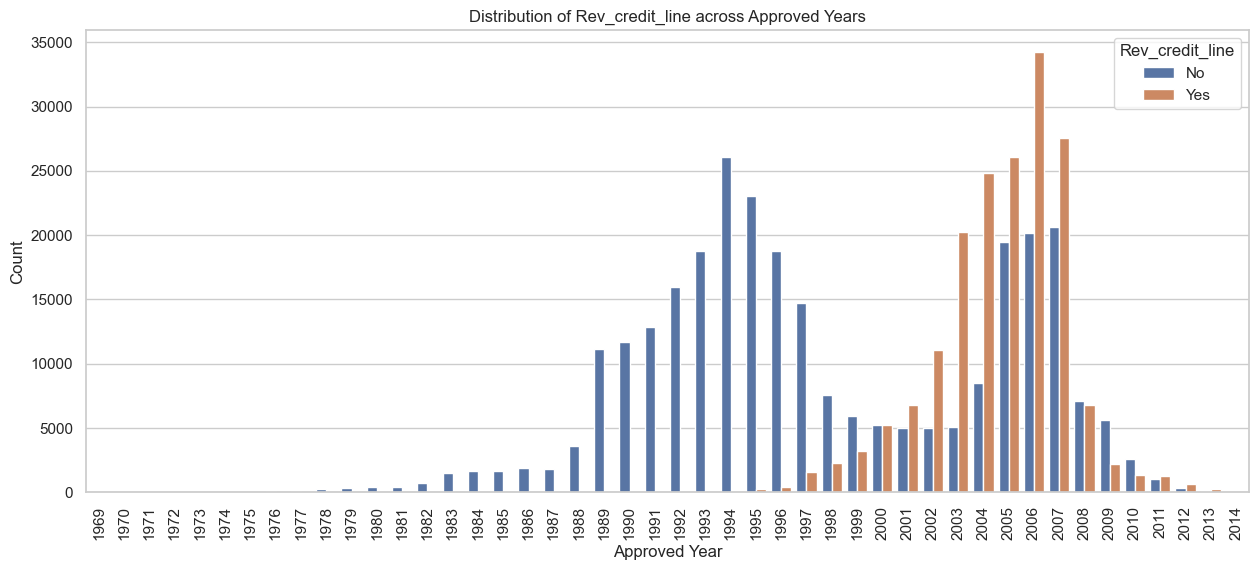

In [436]:
#set wide figure size
plt.figure(figsize=(15, 6))  # Set a wider figure size (width, height)

#create a countplot
sns.countplot(x='approved_year', hue='Rev_credit_line', data=df)

#plot labels
plt.xlabel('Approved Year')
plt.ylabel('Count')
plt.title('Distribution of Rev_credit_line across Approved Years')
plt.legend(title='Rev_credit_line', labels=['No', 'Yes'])

#rotate ticks to vertical so the values can be seen
plt.xticks(rotation=90); 

fillna from `approval_date` 1999 and below to 0. Then try to get value counts for yes and no based on groupby approval year and randomly fill values based on those percentages. OR maybe fill all years based on the groupby. If the groupby is to hard then figure out percentage of yes and no after 2000 and just fill all values randomly based on that.

In [351]:
#
probs = df['Urban'].value_counts(normalize=True)
probs

Urban
1.0    0.870827
0.0    0.129173
Name: proportion, dtype: float64

In [350]:
#checkpoint. Delete at the end
fr=df.copy

In [188]:
#create dummy columns and drop the 'undefined column'
df = dummy_cols_and_drop(df, 'UrbanRural', 'undefined')

#preview the new df
df.head()

,LoanNr_ChkDgt,City,Zip,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,BalanceGross,ChgOffPrinGr,...,State_WA,State_WI,State_WV,State_WY,Existing,Rev_credit_line,Low_doc_loan,Paid,UrbanRural_rural,UrbanRural_urban
0,1000014003,EVANSVILLE,47711,84,4,0,0,60000.0,0.0,0.0,...,0,0,0,0,0.0,0.0,1.0,1,0,0
1,1000024006,NEW PARIS,46526,60,2,0,0,40000.0,0.0,0.0,...,0,0,0,0,0.0,0.0,1.0,1,0,0
2,1000034009,BLOOMINGTON,47401,180,7,0,0,287000.0,0.0,0.0,...,0,0,0,0,1.0,0.0,0.0,1,0,0
3,1000044001,BROKEN ARROW,74012,60,2,0,0,35000.0,0.0,0.0,...,0,0,0,0,1.0,0.0,1.0,1,0,0
4,1000084002,PLAINVILLE,6062,120,19,0,0,517000.0,0.0,0.0,...,0,0,0,0,1.0,0.0,0.0,1,0,0


In [189]:
df.shape
#this shape does include bankstate and regular state that were ohe into 50 col each

(687608, 151)

B4 modeling deal with the class imbalance, undersample the larger side, and oversample with smote the smaller side.